In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
plt.rcParams['savefig.facecolor']='white'
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
# get the right red/blue shades
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

# vid names as saved in behavioral data
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

In [4]:
#loading shen atlas labels
pd.set_option('display.max_colwidth', None) # so columns are not snipped
# loading the Shen atlas labels
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()
# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


In [5]:
# load responses (nsubs * nmovies, values 0 for "no", 1 for "yes", "9" for unsure )
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses[0,:]

array([nan,  0.,  1., nan, nan,  1.,  1.,  0.,  1.,  9.])

In [6]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)

tr_compensate = 1 # move TR back and low-level regs forward, change to 0 for what we had before
if tr_compensate==1:
    vid_start_rel_tr -= 1 # vid_start_rel_tr stored are the first timepts AFTER t=0 (these were created for regressors originally, so without subtracting 1, each index
# we get (7, 14 etc.) was when the first nonzero regressor value was to be assigned)
# so without subtracting 1, we could potentially have been losing the earliest TR (check preprocess step 1_1 to verify)
print(vid_start_rel_tr)

l_task = 28
def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):
    # remove unnecessary BOLD timepts (everything not in the range [-3:28])
    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan
    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1

[6 13 13 13 13 6 13 13 13 13]


In [7]:
#select subs who responded "Social" to the yes movie and "Non-social" to the no movie
print('\nrun-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_zscorenorm.npy') # load fmri data
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_run_z.shape)
tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind)
print('after:',tcs_run_z.shape)


run-wise norm data.
before: (1048, 268, 56, 10)
after: (1048, 268, 31, 10)


<AxesSubplot:>

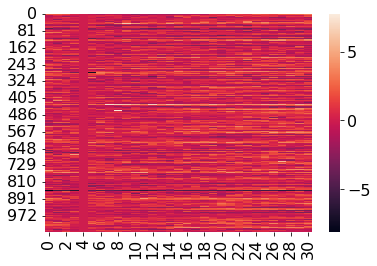

In [8]:
# if it's the 5th index that is 0, that means baseline correction was wrong. it should've been the 4th index. let's correct this/
sns.heatmap(tcs_run_z[:,0,:,0])

In [9]:
tr_compensate

1

in


<AxesSubplot:>

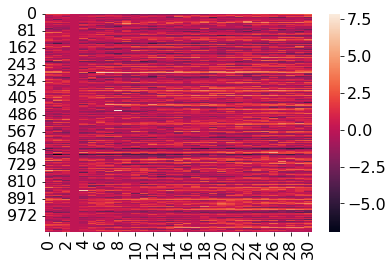

In [10]:
if tr_compensate==1:
    if len(np.where(tcs_run_z[:,0,tr0_ind+1,2]==0)[0]) == tcs_run_z.shape[0]:
        print('in')
        for s in range(tcs_run_z.shape[0]):
            for n in range(tcs_run_z.shape[1]):
                for m in range(10):
                    tcs_run_z[s,n,:,m]  = tcs_run_z[s,n,:,m] - tcs_run_z[s,n,tr0_ind,m]
sns.heatmap(tcs_run_z[:,0,:,0])

In [11]:
import time
from joblib import cpu_count
from pymer4.models import Lmer,Lm
from multiprocessing import Pool
from sklearn.linear_model import LinearRegression
from joblib import Parallel,delayed

In [12]:
# first of all, best to remove subjects with < 10 responses for power in general (and to keep consistent with beh results on all movies)
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0]) # nr. of responses per sub
#subs_10resp = np.where(count_resp == 10)[0]
subs_10resp = count_resp == 10
nsubs = len(np.where(subs_10resp)[0])
len(np.where(subs_10resp)[0])

814

In [13]:
subs_10resp_subs = np.where(subs_10resp)[0]
subs_10resp_subs.shape,subs_10resp.shape
nsubs = np.where(subs_10resp_subs)[0].shape[0]
nsubs

814

In [14]:
# save responses as texts with "Social", "Nonsocial" and "Neither" (so only for social v. non social comparisons) - useful for LMEs
responses_txt = []
for m in range(10):
    temp_txt = []
    temp = responses[:,m]
    for t in temp:
        if ~np.isnan(t):
            if int(t) == 1:
                temp_txt.append('Social')
            elif int(t) == 0:
                temp_txt.append('Nonsocial')
            else:
                temp_txt.append('Neither')    
        else:
            temp_txt.append('Neither')
    responses_txt.append(temp_txt) # list of 10, each item has 1048 elements

In [15]:
# preparing for the lme by defining the long 1Darray
responses_txt_minus_coaxbill_col=[] # store responses as a long 1D array (list)
subID_minus_coaxbill = []
movie_minus_coaxbill = []
for m in np.arange(2,10):
    responses_txt_minus_coaxbill_col.extend(list(np.array(responses_txt[m])[subs_10resp]))
    subID_minus_coaxbill.extend(np.where(subs_10resp)[0])
    movie_minus_coaxbill.extend(np.repeat(m,nsubs))
len(responses_txt_minus_coaxbill_col),len(subID_minus_coaxbill),len(movie_minus_coaxbill)

(6512, 6512, 6512)

In [16]:
# Setting up the dataframe with 8 movies and subs with all 10 responses for use in LME function below!
nsubs = len(np.where(subs_10resp)[0])
rows = []
mmin,mmax = 2,10
for m in np.arange(mmin,mmax):
    rows.append(np.arange((m-mmin)*nsubs,((m-mmin)+1)*nsubs))
rows[0][:10],rows[1][:10]

df = pd.DataFrame({'BOLD':np.empty((6512,)),'response':responses_txt_minus_coaxbill_col,'subID':subID_minus_coaxbill})#,'movie':movie_minus_coaxbill})   
print('Before:',df.shape) 
sel_rows = (df['response']== 'Nonsocial') | (df['response']== 'Social')# (df['response']!= 'Neither') & (df['response']!= 'Unsure')
print('After: nr. of rows with yes/no responses:',len(np.where(sel_rows)[0]))
df = df.loc[sel_rows,:] # yes v no, all movies, remove all other responses
bold = np.empty((6512,))#nsubs*(mmax-mmin),))# 814*8 rows

Before: (6512, 3)
After: nr. of rows with yes/no responses: 6058


In [20]:
# in theory we can combine htis and the later code snippet with AUC - but it's nice to have this funtction like this so we can visualize all sig nodes!! (same for rand and coax-bill too)
def lme_across_time_nocoaxbill(tcs_run_z_node):
    # takes a nodes' timecourse (input dims: subjects * timepts * movies) and performs and LME on the Social vs. Non-social responses across all movies
    # Rreturns a list of [reg coefft, pvalue] - each list elemnet has a length of 31 (i.e., same as tcs_runs_z.shapep[2])
    # in the output, timepts at which the LME did not converge are assigned an np.nan, others have respective values
    # input dims = 814*ntimepts*nmovies
    coef_soc_nonsoc, pval_soc_nonsoc = [np.empty((31)) for _ in range(2)]
    coef_soc_nonsoc[:], pval_soc_nonsoc[:] = [np.nan]*2   
    warning_timepts = []
    for timept in np.arange(tr0_ind+1,31):#tcs_run_z.shape[2]):
        bold[:] = np.nan
        for m in np.arange(mmin,mmax):#np.arange(mmin,mmax):
            #bold[rows[m-mmin]] = tcs_run_z_node[:, timept, m]
            bold[rows[m-mmin]] = tcs_run_z_node[:, timept, m]
        df.loc[:,'BOLD'] = bold[sel_rows]
        df1 = df.loc[~np.isnan(df['BOLD']),:]

        model = Lmer('BOLD ~  response + (1|subID)', data=df1) # ff: mean response, rf:subjID
        model.fit(factors={"response":["Nonsocial","Social"]},summary = False, verbose = False, no_warnings=True)
        if len(model.warnings) == 0: # model did converge or had a boundary fit (only warnings i've seen in this case) -> save coefs
            coef_soc_nonsoc[timept], pval_soc_nonsoc[timept] = model.coefs['Estimate'][1],  model.coefs['P-val'][1]
        else: # don't save coefs if there were warnings, but print the warning
            warning_timepts.append(timept)
            #print(model.warnings,'timept:', timept)
    return coef_soc_nonsoc,pval_soc_nonsoc,warning_timepts

# testing above fn.
tcs_node_list = [tcs_run_z[:,n,:,:] for n in range(268)] # 15 secs per timept so that'll be 15*28 ~= 450s for all?
n=0
start_time = time.time()
lme_across_time_nocoaxbill(tcs_run_z[subs_10resp,n,:,:])
print(f'{(time.time()-start_time)/60:.2f}')

0.15


In [17]:
parallelise=1
#if tr_compensate==1:
early_late = 'early'
#else:
#    early_late = 'late'
#early_late

In [21]:
# Yes v No minus coaxbill
load = 0
start_time = time.time()
parallelise = 0
if load: # load LME coefs
    coef_pval_soc_nonsoc_nocoaxbill = np.load(os.path.join(data_file_loc,f'coefs_pvals_alltimepts_allmovies_exceptcoaxbill_{early_late}.npy'),allow_pickle=True)
    print('Loaded..')
else: # do an LME and save results(takes time!)
    tcs_node_list = [tcs_run_z[subs_10resp,n,:,:] for n in range(268)] # 15 secs per timept so that'll be 15*28 ~= 450s for all?
    if parallelise:
        coef_pval_soc_nonsoc_nocoaxbill = Parallel(n_jobs=10)(delayed(lme_across_time_nocoaxbill)(y) for y in tcs_node_list)
    else:
        coef_pval_soc_nonsoc_nocoaxbill =[]
        for n in range(268):
            if n%10 == 0:
               print(f'Node {n+1}: {(time.time()-start_time)/60:.2f}')
            coef_pval_soc_nonsoc_nocoaxbill.append(lme_across_time_nocoaxbill(tcs_node_list[n]))

    np.save(os.path.join(data_file_loc,f'coefs_pvals_alltimepts_allmovies_exceptcoaxbill_{early_late}.npy'), coef_pval_soc_nonsoc_nocoaxbill)
    print(f'LME done. Time taken={(time.time()-start_time)/60:.2f}')

Node 1: 0.00
['boundary (singular) fit: see ?isSingular'] timept: 11
['boundary (singular) fit: see ?isSingular'] timept: 14
['boundary (singular) fit: see ?isSingular'] timept: 12
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 6
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 5
['boundary (singular) fit: see ?isSingular'] timept: 4
Node 11: 1.51
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
Node 21: 3.13
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 5
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular)

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


<AxesSubplot:title={'center':'Coefs per node and timepoint'}>

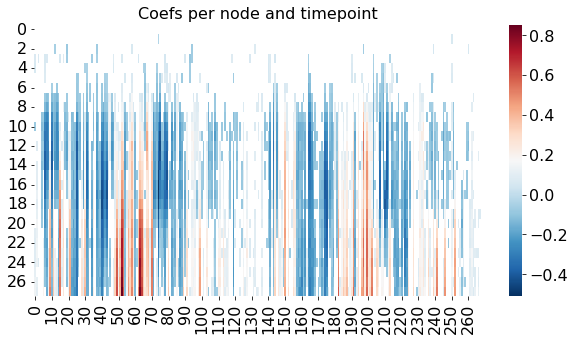

In [23]:
plt.figure(1,figsize=(10,5))
coefs_all_nocoaxbill =  np.empty((268,31))
coefs_all_nocoaxbill[:] = np.nan
for n in range(268):
    coef_,pval_,_ = coef_pval_soc_nonsoc_nocoaxbill[n] # 31 timepts
    coefs_all_nocoaxbill[n,pval_<.05] = coef_[pval_<.05]
plt.title('Coefs per node and timepoint')
sns.heatmap(coefs_all_nocoaxbill[:,tr0_ind:].T,cmap='RdBu_r')


In [30]:
z_score=1
if tr_compensate == 1:
    resid_tc_run = np.load(os.path.join(data_file_loc,'residuals_tc_z_runwise_earlyTR.npy'))
else:
    resid_tc_run = np.load(os.path.join(data_file_loc,'residuals_tc_z_runwise_lateTR.npy'))
resid_tc_run.shape,resid_tc_run[0,10,:,4]

((1048, 268, 31, 10),
 array([ 0.01295272,  0.38800226,  0.09863031,  0.        ,  0.80490405,
         1.46985039,  0.17298541, -0.13416834,  1.11064406,  2.54496857,
         2.85535123,  2.68801064,  2.26934629,  1.55459807,  1.20738258,
         0.80594517,  0.42248178,  0.01798935, -0.02649681, -0.51173218,
        -0.27890641, -0.64366719,  0.10281524, -0.49962244, -0.8859111 ,
        -0.02498484, -0.02794135,  0.20413387, -0.51184441, -1.30142913,
        -0.18907511]))

In [32]:
parallelise=1

In [33]:
# Yes v No minus coaxbill
load = 0
start_time = time.time()
if load==1: # load LME coefs
    coef_pval_soc_nonsoc_nocoaxbill_res = np.load(os.path.join(data_file_loc,f'coefs_pvals_alltimepts_allmovies_exceptcoaxbill_residuals_{early_late}.npy'),allow_pickle=True)
    print('Loaded..')
else: # do an LME and save results(takes time!)
    if parallelise==1:
        print('here')
        #tcs_node_list = [resid_tc_run[:,n,:,:] for n in range(268)] # 15 secs per timept so that'll be 15*28 ~= 450s for all?
        tcs_node_list = [resid_tc_run[subs_10resp,n,:,:] for n in range(268)] # 15 secs per timept so that'll be 15*28 ~= 450s for all?
        coef_pval_soc_nonsoc_nocoaxbill_res = Parallel(n_jobs=10)(delayed(lme_across_time_nocoaxbill)(y) for y in tcs_node_list)
    else:
        coef_pval_soc_nonsoc_nocoaxbill_res =[]
        for n in range(268):
            if n%10 == 0:
               print(f'Node {n+1}: {(time.time()-start_time)/60:.2f}')
            coef_pval_soc_nonsoc_nocoaxbill_res.append(lme_across_time_nocoaxbill(resid_tc_run[subs_10resp,n,:,:]))

    np.save(os.path.join(data_file_loc,f'coefs_pvals_alltimepts_allmovies_exceptcoaxbill_residuals_{early_late}.npy'), coef_pval_soc_nonsoc_nocoaxbill_res)
    print(f'LME done. Time taken={(time.time()-start_time)/60:.2f}')

here
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 5
['boundary (singular) fit: see ?isSingular'] timept: 6
['boundary (singular) fit: see ?isSingular'] timept: 12
['boundary (singular) fit: see ?isSingular'] timept: 14
['boundary (singular) fit: see ?isSingular'] timept: 18
['boundary (singular) fit: see ?isSingular'] timept: 26
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
['boundary (singular) fit: see ?isSingular'] timept: 4
[

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


<AxesSubplot:title={'center':'Coef per node and timepoint, resid'}>

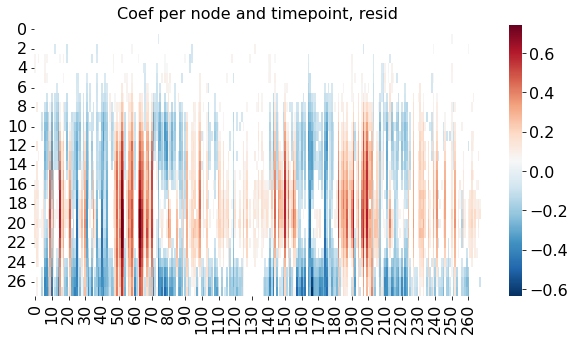

In [35]:
plt.figure(1,figsize=(10,5))
coefs_all_nocoaxbill_resid =  np.empty((268,31))
coefs_all_nocoaxbill_resid[:] = np.nan
for n in range(268):
    coef_,pval_,_ = coef_pval_soc_nonsoc_nocoaxbill_res[n] # 31 timepts
    coefs_all_nocoaxbill_resid[n,pval_<.05] = coef_[pval_<.05]
plt.title('Coef per node and timepoint, resid')
sns.heatmap(coefs_all_nocoaxbill_resid[:,tr0_ind:].T,cmap='RdBu_r')


<AxesSubplot:title={'center':'Coef per node and timepoint, resid'}>

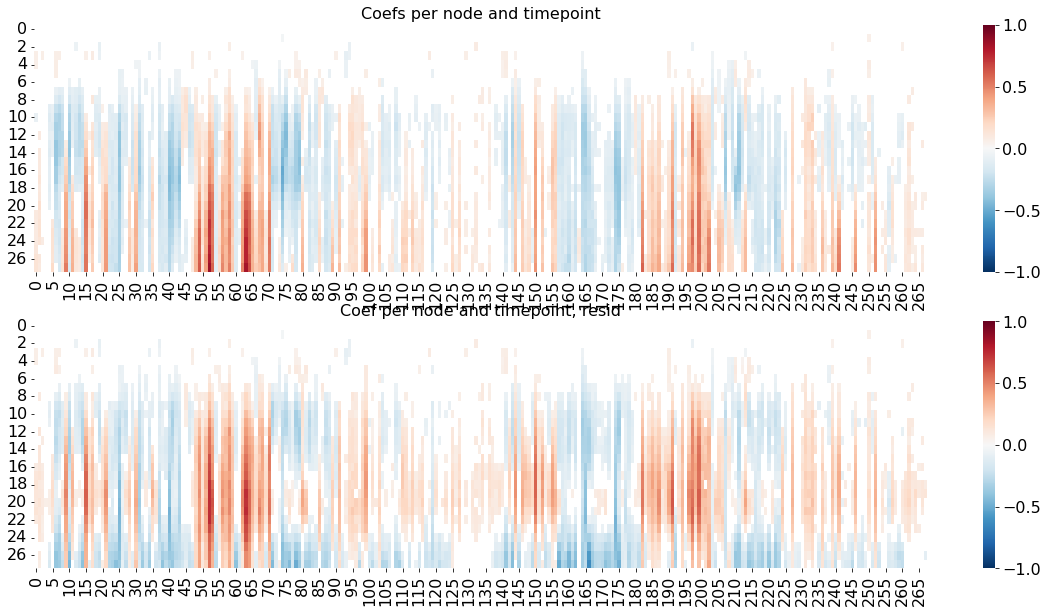

In [36]:
plt.figure(1,figsize=(20,10))
plt.subplot(211)
plt.title('Coefs per node and timepoint')
sns.heatmap(coefs_all_nocoaxbill[:,tr0_ind:].T,cmap='RdBu_r',vmin=-1,vmax=1)

plt.subplot(212)
plt.title('Coef per node and timepoint, resid')
sns.heatmap(coefs_all_nocoaxbill_resid[:,tr0_ind:].T,cmap='RdBu_r',vmin=-1,vmax=1)

In [37]:
# get earliest pt of divergenceALL MOVIES - v1. only criterion is the two consistent pt at the earliest div pt
load = 0 # CHANGE HERE IF NECESSARY
if load == 0:
    earliest_pt_all_nocoaxbill,    sign_earliest_pt_all_nocoaxbill = [np.empty((268,)) for _ in range(2)]
    earliest_pt_all_nocoaxbill[:], sign_earliest_pt_all_nocoaxbill[:] = [np.nan] * 2
    for n in np.arange(0,268): # np.arange(10)
        sig_timepts_nocoaxbill =  np.where(~np.isnan(coefs_all_nocoaxbill[n,:]))[0]
        if n==0:
            print(sig_timepts_nocoaxbill)
        for t in sig_timepts_nocoaxbill:
            if (t < 30) and ((t+1) in sig_timepts_nocoaxbill):
                earliest_pt_all_nocoaxbill[n]      = t #subtract by 3 after this step!!
                sign_earliest_pt_all_nocoaxbill[n] = np.sign(coefs_all_nocoaxbill[n,t])
                break

[ 6  7 13 24 25 26 27 28 29 30]


In [39]:
# get earliest pt of divergenceALL MOVIES - v1. only criterion is the two consistent pt at the earliest div pt
load = 0 # CHANGE HERE IF NECESSARY
if load == 0:
    earliest_pt_all_nocoaxbill_res,    sign_earliest_pt_all_nocoaxbill_res = [np.empty((268,)) for _ in range(2)]
    earliest_pt_all_nocoaxbill_res[:], sign_earliest_pt_all_nocoaxbill_res[:] = [np.nan] * 2
    for n in np.arange(0,268): # np.arange(10)
        sig_timepts_nocoaxbill =  np.where(~np.isnan(coefs_all_nocoaxbill_resid[n,:]))[0]
        if n==0:
            print(sig_timepts_nocoaxbill)
        for t in sig_timepts_nocoaxbill:
            if (t < 30) and ((t+1) in sig_timepts_nocoaxbill):
                earliest_pt_all_nocoaxbill_res[n]      = t #subtract by 3 after this step!!
                sign_earliest_pt_all_nocoaxbill_res[n] = np.sign(coefs_all_nocoaxbill_resid[n,t])
                break

[ 6  7 19 20 21 22 23 24 25]


In [40]:
other_movies = [2,3,4,5,6,7,8,9]

In [41]:
# end diff excl coax-bill
#  NOTE: THIS MODEL DOES NOT ACCOUNT FOR LOW-LEVEL DIFFERENCES - (1) a few movies ended before the 20th second.
'''load=0
if load == 0:
    end_diff_all_nocoaxbill, sign_end_diff_all_nocoaxbill = [np.empty((268,)) for _ in range(2)]
    end_diff_all_nocoaxbill[:], sign_end_diff_all_nocoaxbill[:] = [np.nan]*2
    nodes = np.arange(0,268)# np.arange(10)
    #sub_ind = subs_resh_yes+subs_resh_no
    for n in nodes:
        if n%50 ==0:
            print('node:',n)
        sig_timepts =  np.where(~np.isnan(coefs_all_nocoaxbill[n,:]))[0]
        if len(sig_timepts) > 2: # no pt doing this if there aren't at least 2 sig pts
            tcn1 =[]
            tcn2 = []
            subs1_ind = []
            subs2_ind = []
            for m in other_movies: #np.arange(mmin,mmax):
                subs1 = (subs_10resp) & (responses[:,m]==1)
                subs2 = (subs_10resp) & (responses[:,m]==0) 
                tcn1.extend(np.nanmean(tcs_run_z[subs1,n,-2:,m],axis=1)) # average across the last 2 timepts and append (dims: nsubs * nmovies)
                tcn2.extend(np.nanmean(tcs_run_z[subs2,n,-2:,m],axis=1)) #np.nanmean(tcs_run_resh_no[:, n,-2:],axis=1)
                subs1_ind.extend(np.where(subs1)[0])
                subs2_ind.extend(np.where(subs2)[0])
            #tcn = tcn1 + tcn2
            responses_1d = ['Social'] * len(tcn1) + ['Nonsocial'] * len(tcn2)
            sub_ind =  subs1_ind + subs2_ind

            df= pd.DataFrame({'end_t':np.concatenate((tcn1,tcn2)),'response':responses_1d,'subID':sub_ind})
            model = Lmer('end_t ~  response + (1|subID)', data=df) # ff: mean response, rf:subjID
            model.fit(factors={"response":["Nonsocial","Social"]},summary = False, verbose = False, no_warnings=True)

            if len(model.warnings) == 0: # model did converge -> save coefs
                coef_end,pval_end = model.coefs['Estimate'][1],model.coefs['P-val'][1]
                if pval_end < .05:
                    end_diff_all_nocoaxbill[n], sign_end_diff_all_nocoaxbill[n] = 1, np.sign(coef_end)
    print('Done.')'''

'load=0\nif load == 0:\n    end_diff_all_nocoaxbill, sign_end_diff_all_nocoaxbill = [np.empty((268,)) for _ in range(2)]\n    end_diff_all_nocoaxbill[:], sign_end_diff_all_nocoaxbill[:] = [np.nan]*2\n    nodes = np.arange(0,268)# np.arange(10)\n    #sub_ind = subs_resh_yes+subs_resh_no\n    for n in nodes:\n        if n%50 ==0:\n            print(\'node:\',n)\n        sig_timepts =  np.where(~np.isnan(coefs_all_nocoaxbill[n,:]))[0]\n        if len(sig_timepts) > 2: # no pt doing this if there aren\'t at least 2 sig pts\n            tcn1 =[]\n            tcn2 = []\n            subs1_ind = []\n            subs2_ind = []\n            for m in other_movies: #np.arange(mmin,mmax):\n                subs1 = (subs_10resp) & (responses[:,m]==1)\n                subs2 = (subs_10resp) & (responses[:,m]==0) \n                tcn1.extend(np.nanmean(tcs_run_z[subs1,n,-2:,m],axis=1)) # average across the last 2 timepts and append (dims: nsubs * nmovies)\n                tcn2.extend(np.nanmean(tcs_run

In [19]:
load = 1
if load: # load LME coefs
    [earliest_pt_all_nocoaxbill,sign_earliest_pt_all_nocoaxbill] = np.load(os.path.join(data_file_loc,f'earliest_pt_div_allmovies_nocoaxbill_{early_late}.npy'))
    #[end_diff_all_nocoaxbill1,sign_end_diff_all_nocoaxbill] = np.load(os.path.join(data_file_loc,f'end_pt_div_allmovies_nocoaxbill_{early_late}.npy'))
    [earliest_pt_all_nocoaxbill_res,sign_earliest_pt_all_nocoaxbill_res] = np.load(os.path.join(data_file_loc,f'earliest_pt_div_allmovies_nocoaxbill_resid_{early_late}.npy'))
else:
    np.save(os.path.join(data_file_loc,f'earliest_pt_div_allmovies_nocoaxbill_{early_late}.npy'), [earliest_pt_all_nocoaxbill,sign_earliest_pt_all_nocoaxbill])
    #np.save(os.path.join(data_file_loc,f'end_pt_div_allmovies_nocoaxbill_{early_late}.npy'), [end_diff_all_nocoaxbill,sign_end_diff_all_nocoaxbill])
    np.save(os.path.join(data_file_loc,f'earliest_pt_div_allmovies_nocoaxbill_resid_{early_late}.npy'), [earliest_pt_all_nocoaxbill_res,sign_earliest_pt_all_nocoaxbill_res])
    

In [20]:
# plot timecourses with all NODES and  timepts of difference, and highlighting the initial and end pts. with and without coaxbill
plot_all =0 
if plot_all:
    ncols = 6
    nrows= int(np.ceil(268/ncols))
    #fig, axes = plt.subplots(67,4, figsize=(15,150))
    xwidth,yheight = 30,150# .75*nrows*xwidth/ncols
    fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize = (xwidth,yheight))
    fig.set_figwidth(xwidth)
    fig.set_figheight(yheight)

    x_ticks = np.round(np.linspace(0,30,4),2)  
    ymin,ymax = -.6,2
    lbls = [str(i-tr0_ind) for i in x_ticks]
        
    for n in range(268):
        movieTC_yes = tcs_run_resh_yes_nocoaxbill[:,n,:] # nsubs * ntimepts
        movieTC_no  = tcs_run_resh_no_nocoaxbill[:,n,:] # nsubs * ntimepts
        ax[r,c].errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,ls ='--', linewidth=2,label ='"Social"')
        ax[r,c].errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,ls = '--', linewidth=2,label ='"Non-social"')
        sig = np.where(~np.isnan(coefs_all_nocoaxbill[n,:]))[0]
        ax[r,c].plot(sig,np.repeat(-.6,len(sig)),mec = 'grey',ls = 'None',marker = 'o',mfc='w',label ="p<.05unc.(all-CB)")
        ax[r,c].plot(earliest_pt_all_nocoaxbill[n],-.4,color = 'k',ls = 'None',marker = 'v',mfc='w',mec='k',markersize=8,label ="earliest p<.05unc.\n(all-CB)") # earliest_pt still in the 3-31 range
        if end_diff_all_nocoaxbill[n] == 1:
            ax[r,c].plot([29,30],[-.8,-.8],color = 'k',ls = 'None',marker = '^',mfc='w',mec='k',markersize=8,label ='end-pts. p<.05unc.\n(all-CB)') # earliest_pt still in the 3-31 range
        ax[r,c].vlines(tr0_ind,ymin,ymax,color='grey')
        ax[r,c].hlines(0,0,31,color='grey')
        ax[r,c].set_title(f'Node {n+1}')
        if n == 5:
            ax[r,c].legend(bbox_to_anchor=[1.05,1],ncol=2)
        #ax[r,c].vlines(earliest_pt_all[n],ymin,ymax,color = 'k')
        ax[r,c].set_xticks(x_ticks)
        ax[r,c].set_xticklabels(lbls)
    ax[r,c+1].axis('off')
    ax[r,c+2].axis('off')
    plt.tight_layout()
    #plt.savefig(os.path.join(fig_save_loc,'all_movies_timecourses.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

In [21]:
earliest_pt_all_corrected_nocoaxbill = earliest_pt_all_nocoaxbill - tr0_ind
earliest_pt_all_corrected_nocoaxbill_res = earliest_pt_all_nocoaxbill_res - tr0_ind

# Plot brainmaps

In [22]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig5_timecourse/')

In [23]:
#import plotting functions
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
#from nilearn.plotting import plot_glass_brain,plot_stat_map,plot_surf,view_img_on_surf,plot_img
from nilearn.plotting import plot_surf_roi, plot_img, plot_surf_contours,view_surf
from nilearn import datasets,surface,image
import nibabel as nib

#import nilearn
#nilearn.__version__ # .7.0 in py37 env

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

fsaverage = datasets.fetch_surf_fsaverage()

shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
#shen268_lbl

bg_img = datasets.load_mni152_template()

lbl = [str.upper(x[0:4]) for x in vidnames]
lbl

['COAX',
 'BILL',
 'DRIF',
 'FISH',
 'RAND',
 'SCAR',
 'SEDU',
 'STAR',
 'SURP',
 'TENN']

In [24]:
# for comparison with the other main figure if needed
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
len(np.where(nodes_coaxbill_rand_all)[0])

81

In [25]:
def color_rois(values):
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [27]:
#coords = [10*int(i) for i in np.linspace(-4,7,6)]
coords = [-40,-25,-10,0,10,25,40]
TR=.72
time_units = 'sec' # 'sec','TR'
log_scale = 1
cmap ='viridis'
# present all results in seconds

In [37]:
v5_roi = 'v5_association-test_z_FDR_0.01.nii'
v5_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{v5_roi}'
v5_roi_nii = nib.load(v5_roi_loc)

psts_roi = 'psts_association-test_z_FDR_0.01.nii'
psts_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{psts_roi}'
psts_roi_nii = nib.load(psts_roi_loc)

In [38]:
# ALL EXCEPT COAX-BILL, surface p[ot
def surfplotL_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill,ax1,ax2,scale_type='log', max_TR = 5):
    nodes = np.zeros((268,))
    #nodes_ind = (end_diff_all_nocoaxbill==1)&(nodes_coaxbill_rand_all)
    nodes_ind = (nodes_coaxbill_rand_all)
    nodes[nodes_ind] = np.log(earliest_pt_all_corrected_nocoaxbill[nodes_ind] * TR)
    vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin, axes=ax1,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin, axes=ax2,
                                threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cbar = False,view='medial')#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
   
    #title_txt = '(b) ALL EXCEPT COAX-BILL'
    #surf_plot1.axes[0].set_title(title_txt,fontsize=24,color='k')
    # add contour
    texture = surface.vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_left, texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['k'])#,levels = [texture],  labels=['Fig 3 nodes'])
    #plt.savefig(os.path.join(fig_save_loc,'all_except_coaxbill/surfplot_LH.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

    v5_texture = surface.vol_to_surf(v5_roi_nii,                          fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(v5_texture,.99)
    v5_texture[v5_texture<thr99] = 0
    v5_texture[v5_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_left, v5_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_left, v5_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])

    psts_texture = surface.vol_to_surf(psts_roi_nii,                          fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(psts_texture,.99)
    psts_texture[psts_texture<thr99] = 0
    psts_texture[psts_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_left, psts_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_left, psts_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    
    
def surfplotR_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill,ax1,ax2,subplot_num=2,scale_type='log', max_TR = 5):
    # right
    nodes = np.zeros((268,))
    #nodes_ind = (end_diff_all_nocoaxbill==1)&(nodes_coaxbill_rand_all)
    nodes_ind = (nodes_coaxbill_rand_all)
    nodes[nodes_ind] = np.log(earliest_pt_all_corrected_nocoaxbill[nodes_ind] * TR)
    vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax1,view='medial')
    surf_plot2=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True, vmax = vmax,vmin=vmin,
                                threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cbar = False,axes = ax2)
    
    tks = surf_plot2.axes[subplot_num].get_yticks()
    #tklabels = [.72,5,10,15,20]
    if scale_type == 'log':
        #tks = np.log(tklabels)
        tklabels = [np.round(i,1) for i in np.exp(tks)]
    elif scale_type == 'linear':
        #tks = tklabels
        tklabels = [np.round(i,1) for i in tks]
    surf_plot2.axes[subplot_num].set_yticklabels(tklabels,fontsize=20)
    surf_plot2.axes[subplot_num].text(10,2,s='  Divergence\n  pt. (sec,\n  log scale)',fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})

    # add contour
    texture = surface.vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['k'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['k'])#,labels=['GLM analysis nodes'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    #plt.savefig(os.path.join(fig_save_loc,'all_except_coaxbill/surfplot_RH.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
    v5_texture = surface.vol_to_surf(v5_roi_nii,                          fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(v5_texture,.99)
    v5_texture[v5_texture<thr99] = 0
    v5_texture[v5_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,levels = [texture],  labels=['Fig 3 nodes'])

    psts_texture = surface.vol_to_surf(psts_roi_nii, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(psts_texture,.99)
    psts_texture[psts_texture<thr99] = 0
    psts_texture[psts_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_right, psts_texture, figure=surf_plot1, legend=False, axes=ax1,levels=[1],colors=['r'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, psts_texture, figure=surf_plot2, legend=False, axes=ax2,levels=[1],colors=['r'])#,labels=['V5(top 1%vox)'])#,levels = [nodes_coaxbill_rand_all], , labels=['Fig 3 nodes'])

   
    

#COAX-BILL, axial p[ot
def axplot_allexceptCOAXBILL(earliest_pt_coaxbill_corrected,fig,ax,scale_type='log',dat_type='resid',max_TR = 5):
    nodes = np.zeros((268,))
    #nodes_ind = (end_diff_coaxbill==1) & nodes_coaxbill_rand_all
    nodes_ind = nodes_coaxbill_rand_all    
    nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
    vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))

    img = roi_to_brain(pd.Series(nodes), mask_x)
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, figure=fig,
    cut_coords = coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001,axes=ax)
    ax_plot.add_contours(color_rois((nodes_coaxbill_rand_all)),linewidths=.5, colors='k',linestyles='solid')
    texture = surface.vol_to_surf(v5_roi_nii, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(texture,.99)
    v5_roi_nii_copy = image.threshold_img(v5_roi_nii, thr99)
    ax_plot.add_contours(v5_roi_nii_copy,linewidths=.5, colors='r',linestyles='solid')


In [39]:
early_late

'early'

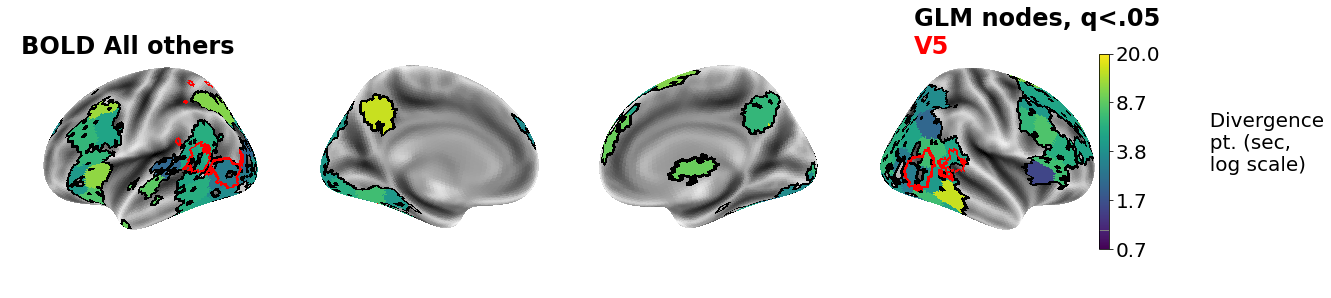

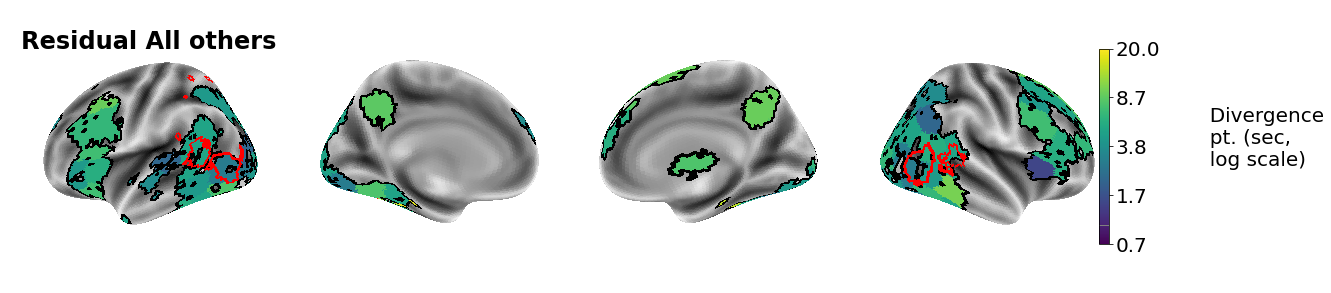

In [40]:
fig,ax = plt.subplots(nrows=1, ncols= 4,figsize=(20,6),subplot_kw={'projection': '3d'})
max_TR =28
surfplotL_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill, ax[0],ax[1],scale_type='log',max_TR = max_TR)
subplot_num = 4
surfplotR_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill, ax[2],ax[3],subplot_num,scale_type='log', max_TR = max_TR)
#plt.tight_layout()
ax[0].annotate('BOLD All others',fontsize=24,fontweight='bold',xy=(.05,.85), xycoords='axes fraction')
ax[3].annotate('GLM nodes, q<.05', xy=(.25,.95), xycoords='axes fraction',fontsize = 24,fontweight='bold')
ax[3].annotate('V5', xy=(.25,.85), xycoords='axes fraction', color='r',fontsize = 24,fontweight='bold')
plt.subplots_adjust(wspace=0.001)
plt.savefig(os.path.join(fig_save_loc,f'all_except_coaxbill/surfplot_both_hem_maxTR{max_TR}_{early_late}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

fig,ax = plt.subplots(nrows=1, ncols= 4,figsize=(20,6),subplot_kw={'projection': '3d'})
max_TR =28
surfplotL_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill_res, ax[0],ax[1],scale_type='log',max_TR = max_TR)
subplot_num = 4
surfplotR_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill_res, ax[2],ax[3],subplot_num,scale_type='log',max_TR = max_TR)
#plt.tight_layout()
ax[0].annotate('Residual All others',fontsize=24,fontweight='bold',xy=(.05,.85), xycoords='axes fraction')
plt.subplots_adjust(wspace=0.001)
plt.savefig(os.path.join(fig_save_loc,f'all_except_coaxbill/surfplot_both_hem_maxTR{max_TR}_resid_{early_late}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


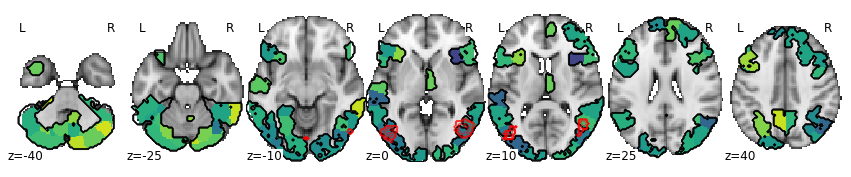

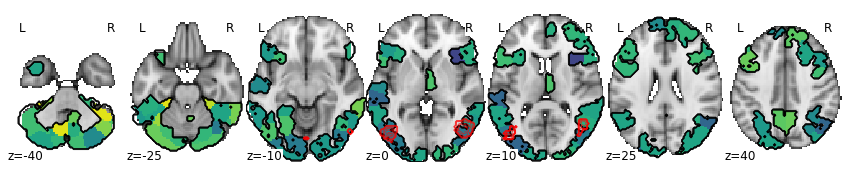

In [68]:
# axial plot
max_TR = 28
fig,ax = plt.subplots(nrows=1, ncols= 1,figsize=(15,3))
axplot_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill,fig,ax,scale_type='log',dat_type='resid',max_TR = max_TR)
plt.savefig(os.path.join(fig_save_loc,f'all_except_coaxbill/axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

# axial plot
fig,ax = plt.subplots(nrows=1, ncols= 1,figsize=(15,3))
axplot_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill_res,fig,ax,scale_type='log',dat_type='resid',max_TR = max_TR)
plt.savefig(os.path.join(fig_save_loc,f'all_except_coaxbill/axial_resid.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

In [36]:
# COAX-BILL, surface p[ot
def view_surfplot_allexceptCOAXBILL(earliest_pt_coaxbill_corrected, max_TR = 5):
    #max_TR = 5
    nodes = np.zeros((268,))
    nodes_ind = nodes_coaxbill_rand_all    
    nodes[nodes_ind] = np.log(earliest_pt_coaxbill_corrected[nodes_ind]*TR)
    vmin,vmax = np.log(.72),np.log(np.round(max_TR*.72))
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    vsurf_plot1=view_surf(fsaverage.infl_left, texture,cmap = cmap, colorbar=True, vmax = vmax,
                            threshold=.01, bg_map=fsaverage.sulc_left,symmetric_cmap = False)        
    texture = surface.vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    vsurf_plot2=view_surf(fsaverage.infl_right, texture,cmap = cmap, colorbar=True, vmax = vmax,
                            threshold=.01, bg_map=fsaverage.sulc_right,symmetric_cmap = False)
    return vsurf_plot1, vsurf_plot2

vsurf_plot1, vsurf_plot2 = view_surfplot_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill,max_TR)
flname = os.path.join(fig_save_loc,f'all_except_coaxbill/view_surfplot_maxTR{max_TR}_{early_late}_Left.html')
vsurf_plot1.save_as_html(flname)
flname = os.path.join(fig_save_loc,f'all_except_coaxbill/view_surfplot_maxTR{max_TR}_{early_late}_Right.html')
vsurf_plot2.save_as_html(flname)

vsurf_plot1, vsurf_plot2 = view_surfplot_allexceptCOAXBILL(earliest_pt_all_corrected_nocoaxbill_res,max_TR)
flname = os.path.join(fig_save_loc,f'all_except_coaxbill/view_surfplot_maxTR{max_TR}_Left_resid.html')
vsurf_plot1.save_as_html(flname)
flname = os.path.join(fig_save_loc,f'all_except_coaxbill/view_surfplot_maxTR{max_TR}_Right_resid.html')
vsurf_plot2.save_as_html(flname)

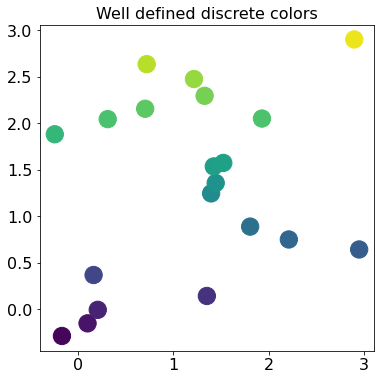

In [151]:
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)


# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))

# define the data between 0 and 20
NUM_VALS = 20
x = np.random.uniform(np.log(.72), np.log(20), size=NUM_VALS)
y = np.random.uniform(np.log(.72), np.log(20), size=NUM_VALS)

# define the color chart between 2 and 10 using the 'autumn_r' colormap, so
#   y <= 2  is yellow
#   y >= 10 is red
#   2 < y < 10 is between from yellow to red, according to its value
#COL = MplColorHelper('viridis', 2, 10)
COL = MplColorHelper('viridis', np.log(.72),np.log(20))

scat = ax.scatter(x,y,s=300, c=COL.get_rgb(y))
ax.set_title('Well defined discrete colors')
plt.show()

In [160]:
y

array([ 2.63542646,  0.36996612,  2.15618068,  2.90067174,  1.24660115,
        2.47555768,  2.0447553 ,  2.2954746 ,  0.64427427,  1.35860658,
        0.75166824, -0.2850882 ,  1.882132  ,  2.05102773,  1.53625334,
        0.89016193, -0.1494668 ,  1.57418945,  0.14479877, -0.00416514])

In [153]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
newcmp = ListedColormap(y)
#newcmp

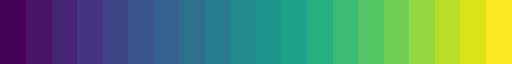

In [166]:
viridis =  cm.get_cmap('viridis', 20)
viridis

In [156]:
colors = [red_rgb,blue_rgb]
# Set your custom color palette
myPalette = sns.set_palette(sns.color_palette(colors))


ValueError: Invalid RGBA argument: 2.635426463041462

In [148]:
sns.heatmap(COL.get_rgb(y),cmap=newcmp)

ValueError: Invalid RGBA argument: 2.9797523587236032

ValueError: Invalid RGBA argument: 2.9797523587236032

<Figure size 432x288 with 2 Axes>